In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [4]:
class CFG:  
    model_type = "efficientnet" # augmented_baseline, efficientnet
    # path defination
    class Path:
        model_type = 'efficientB2'
        train_df = r"D:\EuroSAT\train.csv"
        val_df = r"D:\EuroSAT\validation.csv"
        test_df = r"D:\EuroSAT\test.csv"
        image_folder =r'D:\EuroSAT'
        
        saved_model_folder = '/kaggle/working/weights/'
        model_save_path = f'/kaggle/working/weights/{model_type}_model.h5'
        tensorboard_logs_path = "/kaggle/working/tensorboard/logs/"
        figure_save_path = "/kaggle/working/Figures/"
        
        cm_save_path = f"/kaggle/working/Figures/{model_type}_confusion_matrix.png"
        roc_save_path = f"/kaggle/working/Figures/{model_type}_roc_auc.png"
        loss_acc_save_path = f"/kaggle/working/Figures/{model_type}_loss_acc_curve.png"
        
    # dataset parameter
    class Dataset:
        batch_size = 64
        img_size = (64, 64)
        buffer_size = 1000
    
    class HyperParameter:
        batch_size = 64
        learning_rate = 0.00005
        input_shape = (64, 64, 3)
        num_classes = 10
        epochs = 100

In [8]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import os


class EuroSatLoader:
    def __init__(self, csv_path, image_folder, batch_size = 32, img_size = (32, 32), buffer_size = 100, shuffle = True):
        self.csv_path = csv_path
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.buffer_size = buffer_size
        
        # Load the CSV files using pandas
        self.df = pd.read_csv(self.csv_path)
        # Create a list of image paths and labels for train, validation, and test datasets
        self.image_paths = [os.path.join(self.image_folder, filename) for filename in self.df.Filename] 
        self.labels = self.df.Label.values
        
    def load_image(self, image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3) #
        image = tf.image.resize(image, self.img_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    
    def get_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_paths, self.labels))
        dataset = dataset.map(self.load_image, num_parallel_calls=tf.data.AUTOTUNE)
        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=self.buffer_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size=self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

In [5]:
import tensorflow as tf

# Efficient net without augmentation4
class EfficientNetModel:
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
        
    def build_model(self):
        base_model = tf.keras.applications.efficientnet.EfficientNetB2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        for layer in base_model.layers[:30]:
            layer.trainable = False
        
        x = base_model.output
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        predictions = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
        return model
     
    def compile(self, learning_rate = 0.0001):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self, train_data, val_data, epochs, batch_size, model_save_path, log_dir):
        # self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path , monitor='val_loss', mode='min', save_weights_only=True,save_best_only=True, verbose=1)
        ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitpr = 'val_loss',factor=0.1,patience=3, verbose=1)
        tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
        callbacks = [ReduceLR, early_stop, checkpoint, tensorboard]
        history = self.model.fit(train_data, 
                                 epochs=epochs,
                                 batch_size=batch_size, 
                                 validation_data=val_data, 
                                 callbacks=callbacks)
        return history
    def evaluate(self, data):
        loss, accuracy = self.model.evaluate(data)
        return loss, accuracy
    
    def predict(self, data):
        return self.model.predict(data)
    
    def summary(self):
        return self.model.summary()
    
    def save_model(self, filepath):
        self.model.save(filepath)
        
    def load_model(self, model_path):
        self.model.load_weights(model_path)
        
    def plot_model_architecture(self, file_path):
        tf.keras.utils.plot_model(self, to_file=file_path, show_shapes=True)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

class ModelUtils:
    
    @staticmethod
    def plot_cm(y_true, y_pred, class_names,save_path, figsize=(5,5)):
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        # cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm = pd.DataFrame(cm, index=[i for i in class_names],
                    columns = [i for i in class_names])
        
        cm.index.name = 'True label'
        cm.columns.name = 'Predicted label'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, annot=annot, fmt='', ax=ax)
        plt.savefig(save_path+'confusion_matrix.png')
        
        
    @staticmethod
    def plot_loss_accuracy(save_path,history):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(history.history['loss'], label='train')
        ax[0].plot(history.history['val_loss'], label='validation')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Loss vs Epoch')
        ax[0].legend()
        ax[1].plot(history.history['accuracy'], label='train')
        ax[1].plot(history.history['val_accuracy'], label='validation')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_title('Accuracy vs Epoch')
        ax[1].legend()
        plt.savefig(save_path+'loss_accuracy_curve.png')
        plt.show()

    # function for scoring roc auc score for multi-class
    @staticmethod
    def multiclass_roc_auc_score(y_true, model_predicted_label,class_names,save_path, average="macro"):
        fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
        lb = LabelBinarizer()
        lb.fit(y_true)
        y_test = lb.transform(y_true)
        y_pred = lb.transform(model_predicted_label)
        
        for (idx, c_label) in enumerate(class_names):
            fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
            c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
        
        c_ax.legend()
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        plt.savefig(save_path+'roc_auc_curve.png')
        plt.show()
        return roc_auc_score(y_test, y_pred, average=average)



31790344/31790344 [==============================] - 9s 0us/step
INFO ===========Training Started===============
INFO ===========Running the Training of Model from Scratch===============
Epoch 1/100


296/296 [==============================] - ETA: 0s - loss: 1.1979 - accuracy: 0.5949
Epoch 1: val_loss improved from inf to 2.50970, saving model to /kaggle/working/weights\efficientB2_model.h5
296/296 [==============================] - 443s 1s/step - loss: 1.1979 - accuracy: 0.5949 - val_loss: 2.5097 - val_accuracy: 0.1343 - lr: 5.0000e-05
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.7746
Epoch 2: val_loss improved from 2.50970 to 0.72576, saving model to /kaggle/working/weights\efficientB2_model.h5
296/296 [==============================] - 330s 1s/step - loss: 0.6610 - accuracy: 0.7746 - val_loss: 0.7258 - val_accuracy: 0.7504 - lr: 5.0000e-05
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.827

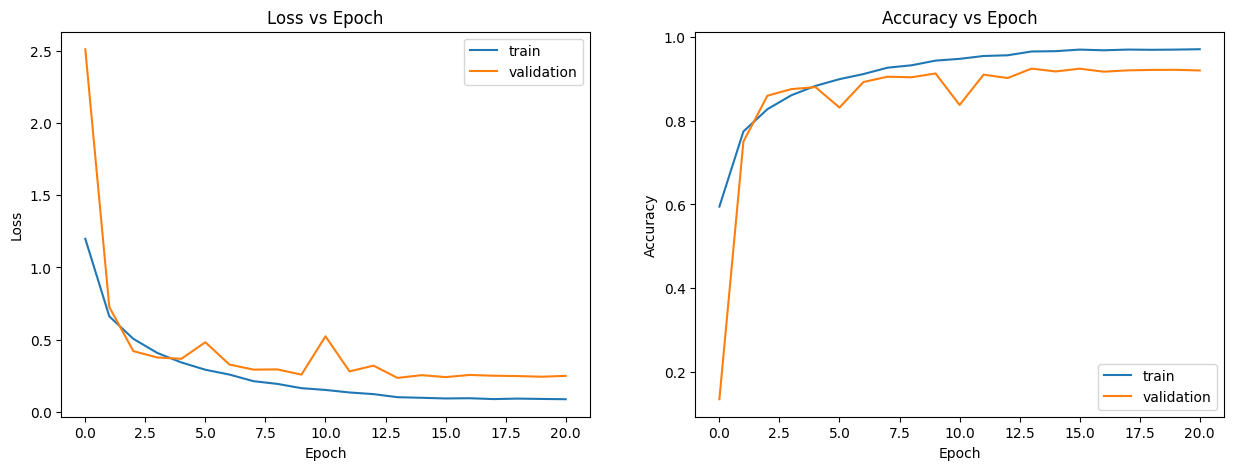

In [9]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

if __name__ == '__main__':
    cfg = CFG()
    Path(cfg.Path.saved_model_folder).mkdir(parents = True, exist_ok = True)
    Path(cfg.Path.tensorboard_logs_path).mkdir(parents = True, exist_ok = True)
    Path(cfg.Path.figure_save_path).mkdir(parents = True, exist_ok = True)

    train_loader = EuroSatLoader(csv_path = cfg.Path.train_df, 
                                image_folder = cfg.Path.image_folder,
                                batch_size = cfg.Dataset.batch_size,
                                img_size = cfg.Dataset.img_size,
                                buffer_size = cfg.Dataset.buffer_size, 
                                shuffle = True)
    train_dataset = train_loader.get_dataset()


    val_loader = EuroSatLoader(csv_path = cfg.Path.val_df, 
                                image_folder = cfg.Path.image_folder,
                                batch_size = cfg.Dataset.batch_size,
                                img_size = cfg.Dataset.img_size,
                                buffer_size = cfg.Dataset.buffer_size, 
                                shuffle = False)
    val_dataset = val_loader.get_dataset()
    test_loader = EuroSatLoader(csv_path = cfg.Path.test_df, 
                                image_folder = cfg.Path.image_folder,
                                batch_size = cfg.Dataset.batch_size,
                                img_size = cfg.Dataset.img_size,
                                buffer_size = cfg.Dataset.buffer_size, 
                                shuffle = False)
    test_dataset = test_loader.get_dataset()
    
    model = EfficientNetModel(input_shape = cfg.HyperParameter.input_shape, 
                        num_classes = cfg.HyperParameter.num_classes)
    
    print(f"INFO ===========Training Started===============")
    model.compile(learning_rate= cfg.HyperParameter.learning_rate)
#     print(model.summary())
    
    if os.path.isfile(cfg.Path.model_save_path):
        print("INFO ===========Running the Partially Trained Model===============")
        #This code is implemented to load the partly trained model which was stopped due to some reason
        model.load_model(cfg.Path.model_save_path)
        history = model.train(train_data = train_dataset, 
                          val_data = val_dataset,
                          epochs = cfg.HyperParameter.epochs,
                          batch_size= cfg.HyperParameter.batch_size, 
                          model_save_path= cfg.Path.model_save_path,
                          log_dir= cfg.Path.tensorboard_logs_path)
    else:
        print("INFO ===========Running the Training of Model from Scratch===============")
        # model.compile(learning_rate= cfg.HyperParameter.learning_rate)
        history = model.train(train_data = train_dataset, 
                          val_data = val_dataset,
                          epochs = cfg.HyperParameter.epochs,
                          batch_size= cfg.HyperParameter.batch_size, 
                          model_save_path= cfg.Path.model_save_path,
                          log_dir= cfg.Path.tensorboard_logs_path)
        
    print(f"INFO ===========Training Finished===============")
    print(f"INFO ===========Plot Curve===============")
    ModelUtils.plot_loss_accuracy(cfg.Path.loss_acc_save_path,history)
    

In [ ]:
model.load_model(cfg.Path.model_save_path)
    
train_loss, train_acc = model.evaluate(train_dataset)
print(f"train_loss:{train_loss}:: train_accuracy: {train_acc}")
    
val_loss, val_acc = model.evaluate(val_dataset)
print(f"val_loss:{val_loss}:: val_acc: {val_acc}")
    
test_loss, test_acc = model.evaluate(test_dataset)
print(f"test_loss:{test_loss}:: test_acc: {test_acc}")
        
predictions = model.predict(test_dataset)
predicted_label = np.argmax(predictions, axis = 1)

class_names = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial",
                   "Pasture","PermanentCrop","Residential","River","SeaLake"]
    
true_labels = []
for image, label in test_dataset:
    true_labels += list(label.numpy())
    
    # Plot confusion Matrix
ModelUtils.plot_cm(y_true = true_labels, y_pred = predicted_label, class_names = class_names,save_path=cfg.Path.cm_save_path, figsize=(18,18))
    #Plot Roc Auc Curve
ModelUtils.multiclass_roc_auc_score(y_true= true_labels, model_predicted_label= predicted_label,class_names = class_names,save_path=cfg.Path.roc_save_path)

296/296 [==============================] - 64s 214ms/step - loss: 0.0202 - accuracy: 0.9970
train_loss:0.020165469497442245:: train_accuracy: 0.9970370531082153
85/85 [==============================] - 25s 288ms/step - loss: 0.2353 - accuracy: 0.9250
val_loss:0.23530271649360657:: val_acc: 0.925000011920929
 6/43 [===>..........................] - ETA: 15s - loss: 0.2397 - accuracy: 0.9323